In [1]:
# Import correct path
import os,sys
g_selfatt_source =  os.path.join(os.getcwd(), '..')
if g_selfatt_source not in sys.path:
    sys.path.append(g_selfatt_source)
    
g_selfatt_source_2 = os.path.join(g_selfatt_source, 'src')
if g_selfatt_source_2 not in sys.path:
    sys.path.append(g_selfatt_source_2)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from datasets import MNIST_rot
import torchvision.transforms.functional as TF
from PIL import Image, ImageOps
import models
import g_selfatt.groups as groups

/Users/jasper/opt/anaconda3/envs/MAIN_environment/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jasper/opt/anaconda3/envs/MAIN_environment/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/jasper/opt/anaconda3/envs/MAIN_environment/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/jasper/opt/anaconda3/envs/MAIN_environment/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/jasper/opt/anaconda3/envs/MAIN_environment/lib/python3.8/site-packages/tor

In [3]:
# First create a dataloader with batchsize one
data_mean = (0.1307,)
data_stddev = (0.3081,)
transform_test = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(data_mean, data_stddev),
    ]
)
test_set = MNIST_rot(root="../data", stage="train", download=True, transform=transform_test, data_fraction=1, only_3_and_8=True)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

Now get one data image and push it through the model

In [4]:
# Get datapoint
data = iter(test_loader)
for _ in range(19): #Cherry picked the 12th image
    image, idx = next(data)

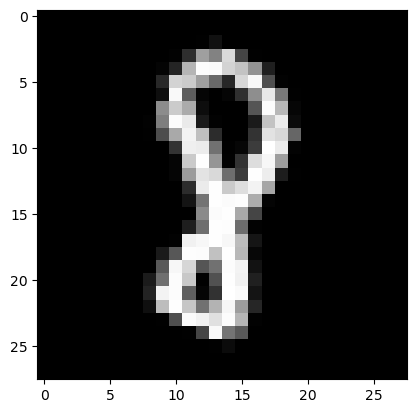

In [5]:
image_plot = image.squeeze()  # Batch dimension
plt.imshow(image_plot.cpu().numpy(), cmap="gray")
plt.show()

### Load the model

In [6]:
# # Wrong

# model = models.GroupTransformer(
#     group=groups.E2(num_elements=8),
#     in_channels=1,
#     num_channels=20,
#     block_sizes=[2, 3],
#     expansion_per_block=1,
#     crop_per_layer=[2, 0, 2, 1, 1],
#     image_size=28,
#     num_classes=2,
#     dropout_rate_after_maxpooling=0.0,
#     maxpool_after_last_block=False,
#     normalize_between_layers=False,
#     patch_size=5,
#     num_heads=9,
#     norm_type="LayerNorm",
#     activation_function="Swish",
#     attention_dropout_rate=0.1,
#     value_dropout_rate=0.1,
#     whitening_scale=1.41421356,
# )
# model_path = "../src/saved/results/rotMNIST_model_p4msa_type_Local_patch_5_dpatt_0.1_dpval_0.1_activ_Swish_norm_LayerNorm_white_1.41421356_optim_Adam_lr_0.001_bs_16_ep_50_wd_0.0001_seed_0_sched_constants_schdec_1.0.pt"
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

In [7]:
# Load model with 10 classes

model = models.GroupTransformer(
    group=groups.SE2(num_elements=4),
    in_channels=1,
    num_channels=20,
    block_sizes=[2, 3],
    expansion_per_block=1,
    crop_per_layer=[2, 0, 2, 1, 1],
    image_size=28,
    num_classes=10,
    dropout_rate_after_maxpooling=0.0,
    maxpool_after_last_block=False,
    normalize_between_layers=False,
    patch_size=5,
    num_heads=9,
    norm_type="LayerNorm",
    activation_function="Swish",
    attention_dropout_rate=0.1,
    value_dropout_rate=0.1,
    whitening_scale=1.41421356,
)

print(f"The working directory is {os.getcwd()}")
model_path = "Checkpoints_visualisations_rotations/rotMNIST_model_p4sa_type_Local_patch_5_dpatt_0.1_dpval_0.1_activ_Swish_norm_LayerNorm_white_1.41421356_optim_Adam_lr_0.0005_bs_64_ep_500_wd_0.0001_seed_0_sched_constants_schdec_1.0.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

The working directory is /Users/jasper/Library/CloudStorage/GoogleDrive-jasper.eppink@gmail.com/My Drive/Documents/school/Master/AI/Jaar 1/Deep Learning 2/Project/Project git MAIN/GEVit-DL2-Project/demos


<All keys matched successfully>

In [8]:
def rotate_image(image, degree, show=False):
    """ Returns all transformations of the input images """
    # First change image from tensor to PIL
    image = image.squeeze()
    image = image.cpu().numpy()
    image = Image.fromarray(image)
    
    transform = TF.rotate(image, degree)

    # Now convert back to tensor
    transform = TF.to_tensor(transform)
    transform = transform.squeeze()
    if show:
        plt.imshow(transform.cpu().numpy(), cmap="gray")
        plt.show()


    return transform  # C, H, W

## Now create the visualisation of the digit with the slider for GE-VIT

In [9]:
#%matplotlib widget
#!conda install jupyter-matplotlib
def get_output_gevit(image, model, device):
    """ Returns the output of the model for the input image """
    model.eval()
    with torch.no_grad():
        output = model(image.to(device))
        probs = torch.softmax(output, dim=1)
        prob_values = probs.cpu().numpy()
        prob_values = prob_values.squeeze()
    return prob_values

In [10]:
%matplotlib widget

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


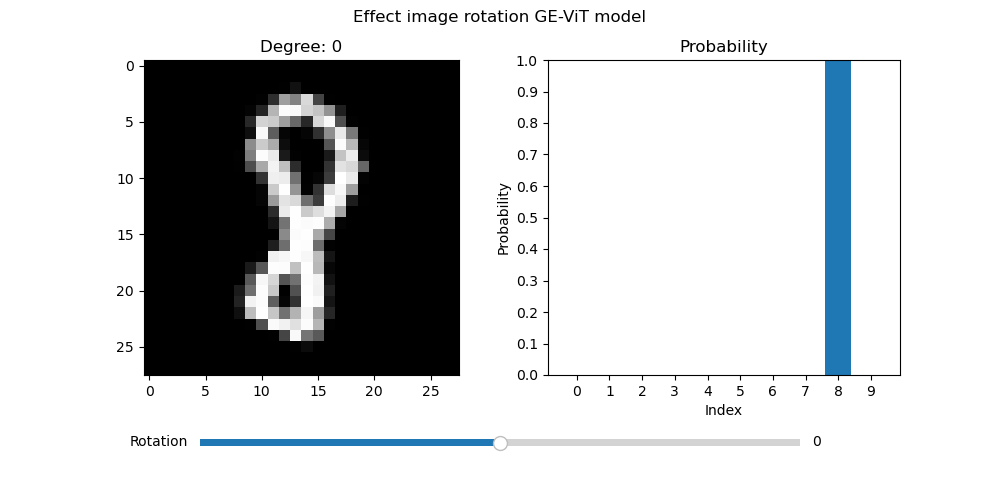

In [11]:
from matplotlib.widgets import Button, Slider

# The image I want to show rotated is image, now I want to create a slider that rotates the image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(bottom=0.25)

# Left image
degree = 0
rotated_image = rotate_image(image, degree)
image_plot = ax1.imshow(rotated_image.cpu().numpy(), cmap="gray")
ax1.set_title("Degree: {}".format(degree))


# Right barplot image
prob_values = get_output_gevit(image, model, device)
barplot = ax2.bar(list(range(len(prob_values))), prob_values)

# Set the labels and title
ax2.set_xlabel('Index')
ax2.set_ylabel('Probability')
ax2.set_title('Probability')
ax2.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax2.set_ylim([0, 1])
ax2.xaxis.set_ticks(np.arange(0, 10, 1))

# Set a title for the figure
fig.suptitle("Effect image rotation GE-ViT model")


# Define the slider update function
def update_rotation(val):
    degree = val
    rotated_image = rotate_image(image, degree)
    image_plot.set_data(rotated_image.cpu().numpy())
    updated_prob_values = get_output_gevit(rotated_image.unsqueeze(0).unsqueeze(0), model, device)
    for bar, value in zip(barplot, updated_prob_values):
        bar.set_height(value)
    
    ax1.set_title("Degree: {}".format(degree))
    fig.canvas.draw_idle()

# Create the slider
slider_ax = plt.axes([0.2, 0.1, 0.6, 0.03])
slider = Slider(slider_ax, 'Rotation', -180, 180, valinit=degree)
slider.on_changed(update_rotation)

plt.show()

### Now for the standard vision transformer

In [12]:
from src.train_vit import VisionTransformer

In [13]:
# Load the normal vision transformer
model_vit = VisionTransformer(embed_dim=64,
                        hidden_dim=512,
                        num_heads=4,
                        num_layers=6,
                        patch_size=4,
                        num_channels=1,
                        num_patches=49,
                        num_classes=10,
                        dropout=0.1).to(device)

model_path = "Checkpoints_visualisations_rotations/mnist_2555_ViT.pt"
model_vit.load_state_dict(torch.load(model_path, map_location=device), strict=False)


def get_output_ViT(image, model_vit, device):
    """ Returns the output of the model for the input image """
    model_vit.eval()
    with torch.no_grad():
        output = model_vit(image.to(device))
        probs = torch.softmax(output, dim=1)
        prob_values = probs.cpu().numpy()
        prob_values = prob_values.squeeze()
    return prob_values

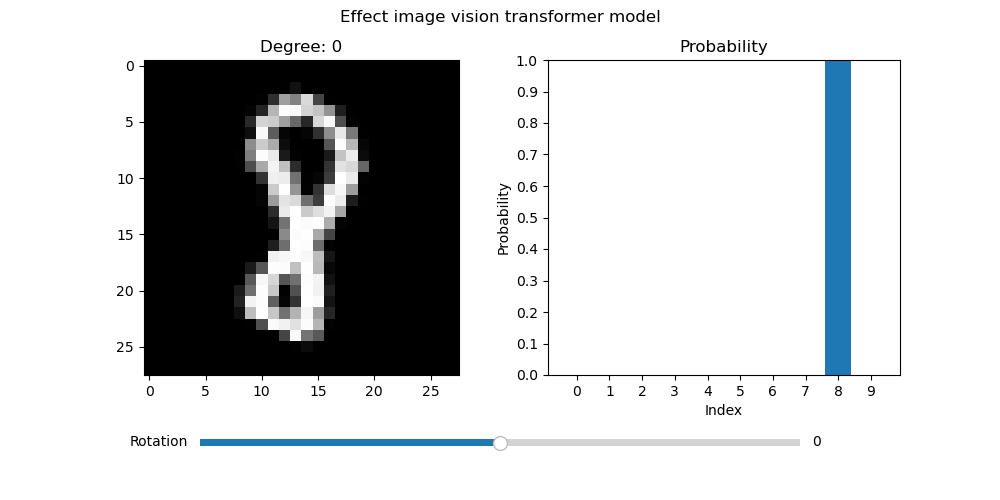

In [14]:
# The image I want to show rotated is image, now I want to create a slider that rotates the image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(bottom=0.25)

# Left image
degree = 0
rotated_image = rotate_image(image, degree)
image_plot = ax1.imshow(rotated_image.cpu().numpy(), cmap="gray")
ax1.set_title("Degree: {}".format(degree))


# Right barplot image
prob_values = get_output_ViT(image, model_vit, device)
barplot = ax2.bar(list(range(len(prob_values))), prob_values)

# Set the labels and title
ax2.set_xlabel('Index')
ax2.set_ylabel('Probability')
ax2.set_title('Probability')
ax2.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax2.set_ylim([0, 1])
ax2.xaxis.set_ticks(np.arange(0, 10, 1))

# Set a title for the figure
fig.suptitle("Effect image vision transformer model")


# Define the slider update function
def update_rotation(val):
    degree = val
    rotated_image = rotate_image(image, degree)
    image_plot.set_data(rotated_image.cpu().numpy())
    updated_prob_values = get_output_ViT(rotated_image.unsqueeze(0).unsqueeze(0), model_vit, device)
    for bar, value in zip(barplot, updated_prob_values):
        bar.set_height(value)
    
    ax1.set_title("Degree: {}".format(degree))
    fig.canvas.draw_idle()

# Create the slider
slider_ax = plt.axes([0.2, 0.1, 0.6, 0.03])
slider = Slider(slider_ax, 'Rotation', -180, 180, valinit=degree)
slider.on_changed(update_rotation)

plt.show()

### Now in one figure

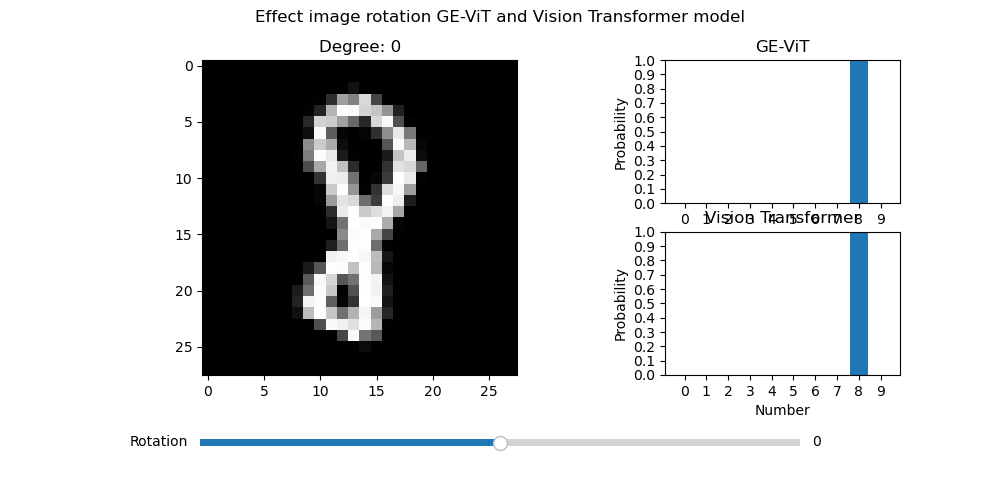

In [16]:
fig = plt.figure(figsize=(10, 7))

# Create the gridspec 
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], hspace=0.5, wspace=0.3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

# Left image
degree = 0
rotated_image = rotate_image(image, degree)
image_plot = ax1.imshow(rotated_image.cpu().numpy(), cmap="gray")
ax1.set_title("Degree: {}".format(degree))

# Right barplot image GE-ViT
prob_values = get_output_gevit(image, model, device)
barplot1 = ax2.bar(list(range(len(prob_values))), prob_values)
ax2.set_xlabel('Number')
ax2.set_ylabel('Probability')
ax2.set_title('GE-ViT')
ax2.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax2.set_ylim([0, 1])
ax2.xaxis.set_ticks(np.arange(0, 10, 1))

# Right barplot image lower vision transformer
prob_values = get_output_ViT(image, model_vit, device)
barplot2 = ax3.bar(list(range(len(prob_values))), prob_values)
ax3.set_xlabel('Number')
ax3.set_ylabel('Probability')
ax3.set_title('Vision Transformer')
ax3.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax3.set_ylim([0, 1])
ax3.xaxis.set_ticks(np.arange(0, 10, 1))

# Set a title for the figure
fig.suptitle("Effect image rotation GE-ViT and Vision Transformer model")

# Define the slider update function
def update_rotation(val):
    degree = val
    rotated_image = rotate_image(image, degree)
    image_plot.set_data(rotated_image.cpu().numpy())
    updated_prob_values_gevit = get_output_gevit(rotated_image.unsqueeze(0).unsqueeze(0), model, device)
    updated_prob_values_vit = get_output_ViT(rotated_image.unsqueeze(0).unsqueeze(0), model_vit, device)
    for bar1, value1, bar2, value2 in zip(barplot1, updated_prob_values_gevit, barplot2, updated_prob_values_vit):
        bar1.set_height(value1)
        bar2.set_height(value2)
    
    ax1.set_title("Degree: {}".format(degree))
    fig.canvas.draw_idle()
    
# Create the slider
slider_ax = plt.axes([0.2, 0.1, 0.6, 0.03])
slider = Slider(slider_ax, 'Rotation', 0, 360, valinit=degree)
slider.on_changed(update_rotation)

plt.subplots_adjust(bottom=0.25)
plt.show()